In [1]:
import pandas as pd
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [42]:
mainpath = "/Users/soldash/Downloads/" #ruta de Carga de los datos
filename = "timestream_data.csv" #Nombre del archivo a cargar

2023-08-30 23:29:23.379000000
SELECT ECG, time FROM "ECG_Records"."ECG" WHERE time BETWEEN timestamp '2023-08-30 23:29:23.379000000' - interval '130' second AND timestamp '2023-08-30 23:29:23.379000000' ORDER BY time ASC
          ECG                    time
0      1003.0 2023-08-30 23:27:13.443
1      1791.0 2023-08-30 23:27:13.494
2      2059.0 2023-08-30 23:27:13.524
3      1942.0 2023-08-30 23:27:13.525
4      2073.0 2023-08-30 23:27:13.526
...       ...                     ...
13120  1939.0 2023-08-30 23:29:23.334
13121  2095.0 2023-08-30 23:29:23.335
13122  2128.0 2023-08-30 23:29:23.337
13123  2083.0 2023-08-30 23:29:23.337
13124  2199.0 2023-08-30 23:29:23.379

[13125 rows x 2 columns]


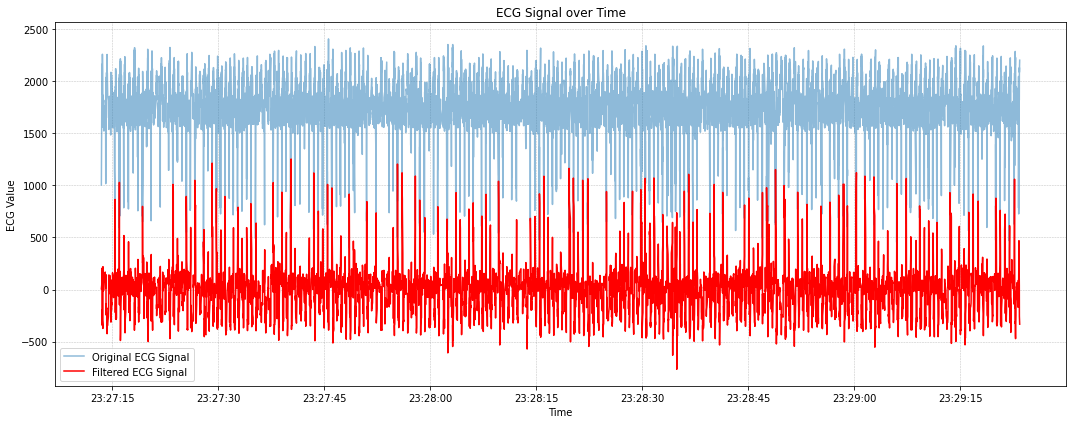

In [315]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, iirnotch
from flask import Flask, jsonify, send_from_directory
from flask_cors import CORS 
import boto3
from botocore.exceptions import BotoCoreError, ClientError
import os

import pyhrv.frequency_domain as fd
import pyhrv.time_domain as td

client = boto3.client('timestream-query')

try:
        # Obtener el último tiempo registrado
        query_latest_time = 'SELECT time FROM "ECG_Records"."ECG" ORDER BY time DESC LIMIT 1'
        response_latest_time = client.query(QueryString=query_latest_time)
        
        latest_time = response_latest_time['Rows'][0]['Data'][0]['ScalarValue']
        print(latest_time)

        # Usar el último tiempo para hacer la consulta de 2 minutos hacia atrás
        query_string = f'SELECT ECG, time FROM "ECG_Records"."ECG" WHERE time BETWEEN timestamp \'{latest_time}\' - interval \'130\' second AND timestamp \'{latest_time}\' ORDER BY time ASC'
        print(query_string)
        response = client.query(QueryString=query_string)

        columns = [col['Name'] for col in response['ColumnInfo']]
        rows = []

        for row in response['Rows']:
            data_row = [value[list(value.keys())[0]] for value in row['Data']]
            rows.append(data_row)
        df = pd.DataFrame(rows, columns=columns)
        
        df['ECG'] = df['ECG'].astype(float)
        df['time'] = pd.to_datetime(df['time'])
        print(df)
        
except (BotoCoreError, ClientError) as e:
    jsonify({"error": str(e)}), 500

# Suponiendo que la frecuencia de muestreo es 1000 Hz (ajusta esto según tus datos)
fs = 500.0

# Ajuste de parámetros
lowpass_cutoff = 80.0
highpass_cutoff = 0.1
notch_cutoff = 60.0  # Si decides eliminar el filtro notch, comenta las líneas relacionadas
order = 5  # Reducir el orden

df['ECG_centered'] = df['ECG'] - df['ECG'].mean()

# Filtra la señal ECG
filtered_ecg_values = df['ECG_centered'].values
filtered_ecg_values = lowpass_filter(filtered_ecg_values, lowpass_cutoff, fs, order)
filtered_ecg_values = highpass_filter(filtered_ecg_values, highpass_cutoff, fs, order)
filtered_ecg_values = notch_filter(filtered_ecg_values, notch_cutoff, 60, fs)



# Añadir la señal filtrada como otra columna
df['filtered_ECG'] = filtered_ecg_values

df['filtered_ECG'] = -df['filtered_ECG']

window_size = 2  # Este es un parámetro que puedes ajustar según tus necesidades
df['smoothed_ECG'] = df['ECG'].rolling(window=window_size, center=True).mean()

# Grafica la señal ECG original, filtrada y suavizada en función del tiempo
plt.figure(figsize=(15,6))

# Señal original
plt.plot(df['time'], df['ECG'], label='Original ECG Signal', alpha=0.5)

# Señal filtrada
plt.plot(df['time'], df['filtered_ECG'], label='Filtered ECG Signal', color='red')

# Señal suavizada
#plt.plot(df['time'], df['ECG_centered'], label='Smoothed ECG Signal', color='green')

plt.title('ECG Signal over Time')
plt.xlabel('Time')
plt.ylabel('ECG Value')
plt.legend()
plt.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

{'RRI': 626.0, 'SDNN': 229.28676597795953, 'HR': 83, 'HR_std': 0.9487879456681954, 'NN50': 28, 'pNN50': 73.68421052631578, 'HF': 151.45106528403315, 'LF': 258.50859908521505, 'Total_power': 17108.106951617865, 'LF_HF': 1.706878710957925}


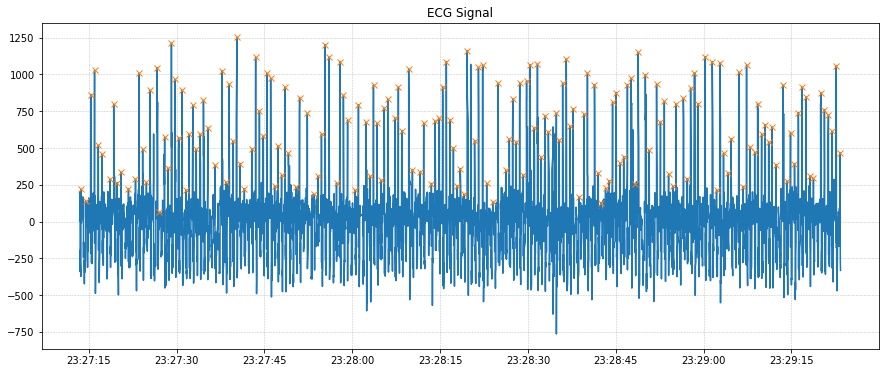

In [338]:
def detect_peaks(data, prominence=(300,8000), width=1, distance=50):
    """Detect peaks in the given data."""
    peaks, _ = find_peaks(data, prominence=prominence, width=width, distance=distance)
    return peaks

def compute_RRI(dataframe, peaks):
    """Compute the R-R interval (RRI)."""
    df = dataframe.copy()
    df['RRI'] = 0
    for i in range(len(peaks)):
        if i != 0:
            RRI = df["time"][peaks[i]] - df["time"][peaks[i-1]]
            RRI = RRI.total_seconds() * 1000
            df.loc[peaks[i-1]:peaks[i], ("RRI")] = RRI
    return df, RRI

def compute_SDNN(subset):
    """Compute the SDNN."""
    subset.drop_duplicates(subset="RRI", keep='last', inplace=True)
    return subset.std()["RRI"]

def compute_HR_for_last_30_seconds(sampleDf, peaks):
    """
    Compute the HR for the last 30 seconds of the given DataFrame.

    Parameters:
    - sampleDf (pd.DataFrame): The input DataFrame with 'time' and 'filtered_ECG' columns.
    - peaks (np.array): An array with the indices of the detected peaks.

    Returns:
    - sampleDf (pd.DataFrame): The updated DataFrame with the 'HR' column added.
    """
    
    # Identifica el tiempo de la última muestra
    last_time = sampleDf['time'].iloc[-1]
    sampleDf['HR'] = 0

    # Identifica el tiempo 30 segundos antes de la última muestra
    start_time = last_time - pd.Timedelta(seconds=30)
    subset_indices = sampleDf[sampleDf['time'] >= start_time].index
    start_index = subset_indices[0] if len(subset_indices) > 0 else None

    for index in range(len(sampleDf) - 1, start_index - 1, -1):
        time = sampleDf['time'].iloc[index]
        start_data = time - pd.Timedelta(seconds=60)

        subset_indices = sampleDf[sampleDf['time'] >= start_data].index
        start_index_hr = subset_indices[0] if len(subset_indices) > 0 else None

        if start_index_hr is not None:
            sampleDf.loc[index, "HR"] = len(peaks[(peaks > start_index_hr) & (peaks < index)])

    return sampleDf


# Sample usage:
sampleDf = df
peaks = detect_peaks(sampleDf["filtered_ECG"])

predict_variables = {
            'RRI': [0],
            'SDNN': [0],
            'HR': [0],
            'HR_std': [0],
            'NN50': [0],
            'pNN50': [0],
            'HF': [0],
            'LF': [0],
            'Total_power': [0],
            'LF_HF': [0]
        }

fbands = {'ulf': (0.0, 0.1), 'vlf': (0.1, 0.2), 'lf': (0.2, 0.3), 'hf': (0.3, 0.4)}

sampleDf, last_RRI = compute_RRI(sampleDf, peaks)
predict_variables["RRI"] = last_RRI

#HR
sampleDf = compute_HR_for_last_30_seconds(sampleDf, peaks)
predict_variables["HR"] = sampleDf[sampleDf['HR'] > 0]['HR'].iloc[-1]
predict_variables["HR_std"] = sampleDf[sampleDf['HR'] > 0]['HR'].std()

sampleDf = sampleDf[sampleDf["RRI"] > 0]

last_time = sampleDf['time'].iloc[-1]
subset = sampleDf[sampleDf['time'] > (last_time - pd.Timedelta(seconds=30))].copy()
predict_variables["SDNN"] = compute_SDNN(subset)

#NN50 y pNN50
resultNN50 = td.nn50(subset["RRI"])
predict_variables["NN50"] = resultNN50["nn50"]
predict_variables["pNN50"] = resultNN50["pnn50"]


#Frecuencia
result = fd.welch_psd(sampleDf["RRI"], mode='dev', fbands=fbands)
predict_variables["HF"] = result[0]["fft_abs"][3]
predict_variables["LF"] = result[0]["fft_abs"][2]
predict_variables["Total_power"] = result[0]["fft_total"]
predict_variables["LF_HF"] = result[0]["fft_ratio"]


plt.figure(figsize=(15,6))
plt.title("ECG Signal")
plt.plot(df["time"], df["filtered_ECG"])
plt.plot(df["time"][peaks], df["filtered_ECG"][peaks], "x")
plt.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

print(predict_variables)

In [327]:
print(peaks)

[   24   107   203   263   332   397   531   582   651   723   824   937
  1020  1094  1157  1222  1328  1380  1473  1529  1591  1652  1715  1775
  1837  1898  1959  2021  2079  2141  2210  2332  2437  2520  2587  2651
  2713  2775  2845  2974  3031  3108  3171  3239  3301  3363  3425  3489
  3551  3605  3737  3800  3924  4022  4085  4136  4221  4304  4432  4486
  4556  4621  4735  4798  4924  5005  5073  5133  5199  5260  5317  5442
  5503  5564  5680  5745  5873  5940  6050  6129  6203  6266  6329  6391
  6451  6513  6567  6622  6688  6819  6884  6957  7023  7131  7225  7355
  7416  7473  7530  7596  7654  7705  7765  7841  7897  7964  8029  8089
  8192  8253  8337  8399  8460  8516  8612  8700  8763  8886  8947  8998
  9070  9134  9196  9259  9324  9384  9448  9499  9560  9635  9744  9826
  9953 10024 10090 10158 10225 10278 10419 10478 10539 10602 10657 10792
 10909 10989 11046 11105 11178 11242 11376 11441 11508 11571 11638 11699
 11766 11829 11889 11947 12011 12131 12185 12260 12

In [332]:
#HR
# Identifica el tiempo de la última muestra
last_time = sampleDf['time'].iloc[-1]
sampleDf['HR'] = 0

# Identifica el tiempo 30 segundos antes de la última muestra
start_time = last_time - pd.Timedelta(seconds=30)
subset_indices = sampleDf[sampleDf['time'] >= start_time].index
start_index = subset_indices[0] if len(subset_indices) > 0 else None

for index in range(len(sampleDf) - 1, start_index - 1, -1):
    time = sampleDf['time'].iloc[index]
    start_data = time - pd.Timedelta(seconds=60)
    
    subset_indices = sampleDf[sampleDf['time'] >= start_data].index
    start_index_hr = subset_indices[0] if len(subset_indices) > 0 else None
    
    if start_index_hr is not None:
        sampleDf.loc[index, "HR"] = len(peaks[(peaks > start_index_hr) & (peaks < index)])
    
print(sampleDf[sampleDf['HR'] > 0])


          ECG                    time  ECG_centered  filtered_ECG  \
10088  1397.0 2023-08-30 23:28:53.280   -352.742095    415.748382   
10089  1872.0 2023-08-30 23:28:53.285    122.257905    707.717974   
10090  1998.0 2023-08-30 23:28:53.289    248.257905    816.791334   
10091  2019.0 2023-08-30 23:28:53.294    269.257905    607.580473   
10092   856.0 2023-08-30 23:28:53.312   -893.742095    182.501274   
...       ...                     ...           ...           ...   
13085  1680.0 2023-08-30 23:29:22.994    -69.742095     14.508496   
13086  1697.0 2023-08-30 23:29:22.994    -52.742095     38.944143   
13087  1629.0 2023-08-30 23:29:23.001   -120.742095     57.872598   
13088  1840.0 2023-08-30 23:29:23.003     90.257905     66.869830   
13089  1740.0 2023-08-30 23:29:23.025     -9.742095     63.618239   

       smoothed_ECG  RRI  HR  
10088        1086.0  665  80  
10089        1634.5  665  80  
10090        1935.0  729  80  
10091        2008.5  729  81  
10092        143

In [313]:
print(sampleDf)
print(sampleDf[sampleDf["RRI"] > 0])
print(predict_variables)

          ECG                    time  ECG_centered  filtered_ECG  \
24     1702.0 2023-08-30 23:27:13.668    -47.742095    217.799447   
25     1555.0 2023-08-30 23:27:13.669   -194.742095    158.084066   
26     1588.0 2023-08-30 23:27:13.670   -161.742095     84.092449   
27     1570.0 2023-08-30 23:27:13.680   -179.742095     57.411860   
28     1746.0 2023-08-30 23:27:13.683     -3.742095     92.328512   
...       ...                     ...           ...           ...   
13109   725.0 2023-08-30 23:29:23.241  -1024.742095    130.054663   
13110  1442.0 2023-08-30 23:29:23.251   -307.742095    230.200335   
13111  1765.0 2023-08-30 23:29:23.254     15.257905    331.643425   
13112  1086.0 2023-08-30 23:29:23.276   -663.742095    429.484522   
13113  1930.0 2023-08-30 23:29:23.277    180.257905    467.432360   

       smoothed_ECG    RRI  
24           1731.5  972.0  
25           1628.5  972.0  
26           1571.5  972.0  
27           1579.0  972.0  
28           1658.0  972.0

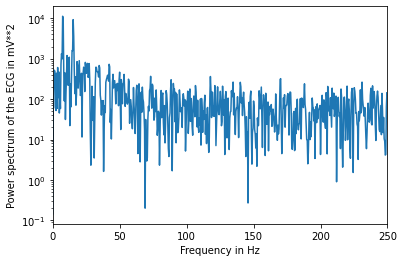

In [218]:
#Ver la potencia de la señal

from scipy.signal import welch
fs = 500.0
f, Pxx = welch(df["ECG"], fs=fs, nperseg=2048, scaling="spectrum")
plt.semilogy(f, Pxx)
plt.xlabel("Frequency in Hz")
plt.ylabel("Power spectrum of the ECG in mV**2")
plt.xlim(f[[0, -1]])
plt.show()

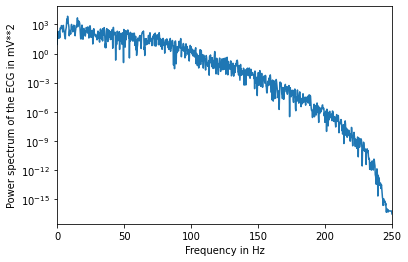

In [240]:
#Ver la potencia de la señal

from scipy.signal import welch
fs = 500.0
f, Pxx = welch(df['filtered_ECG'], fs=fs, nperseg=2048, scaling="spectrum")
plt.semilogy(f, Pxx)
plt.xlabel("Frequency in Hz")
plt.ylabel("Power spectrum of the ECG in mV**2")
plt.xlim(f[[0, -1]])
plt.show()

In [178]:
# Funciones de filtrado
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def notch_filter(data, cutoff, Q, fs):
    nyq = 0.5 * fs
    freq = cutoff / nyq
    b, a = iirnotch(freq, Q)
    y = lfilter(b, a, data)
    return y